# Axis to Regression Registration Pipeline

## Data loading

In [1]:
# auto reload packages installed with -e when they change before running the cell
# this is useful for development so you don't have to restart the kernel each time
# you make a change to the pkg code
%load_ext autoreload
%autoreload 2

from sidus import io, plotting as pl
import pandas as pd
import ants
from wsifir.utils import get_affine_matrix_from_ants
from wsifir.metrics import compute_metrics
from wsifir.utils import ants_from_sdata
from wsifir import plotting as wpl
from wsifir.utils import get_affine_table



c:\Users\molanre1\AppData\Local\miniconda3\envs\wsifir-env\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


ModuleNotFoundError: No module named 'wsifir'

### Load clinical data

In [19]:
#Load the axis,regression and tbet clinical data
ids = pd.read_csv('C:/Users/molanre1/Desktop/WSIFIR/ids.csv')
results = ids.iloc[0].to_dict()
results

{'axis_sampleid': 101,
 'reg_sampleid': 709,
 'tbet_sampleid': 834,
 'axis_slideid': 'L1_2',
 'reg_slideid': 'LY1',
 'tbet_slideid': 'AP0140001'}

In [20]:
fixed_sampleid = results['reg_sampleid']
fixed_slideid = results['reg_slideid']
moving_sampleid = results['axis_sampleid']
moving_slideid = results['axis_slideid']
#
image_id_fixed = f"sampleid_{fixed_sampleid}_image"
fixed_path = "//bki-fs1/data02/Clinical_Specimen_10"
image_id_moving = f"sampleid_{moving_sampleid}_image"
moving_path = "//bki-fs1/data02/Clinical_Specimen_2"
#
# latest sidus version sets other elements to false by default
#
fixed_image = io.load_astropath(
    sampleid=fixed_sampleid, sample_path=f"{fixed_path}/{fixed_slideid}"
)
moving_image = io.load_astropath(
    sampleid=moving_sampleid, sample_path=f"{moving_path}/{moving_slideid}"
)

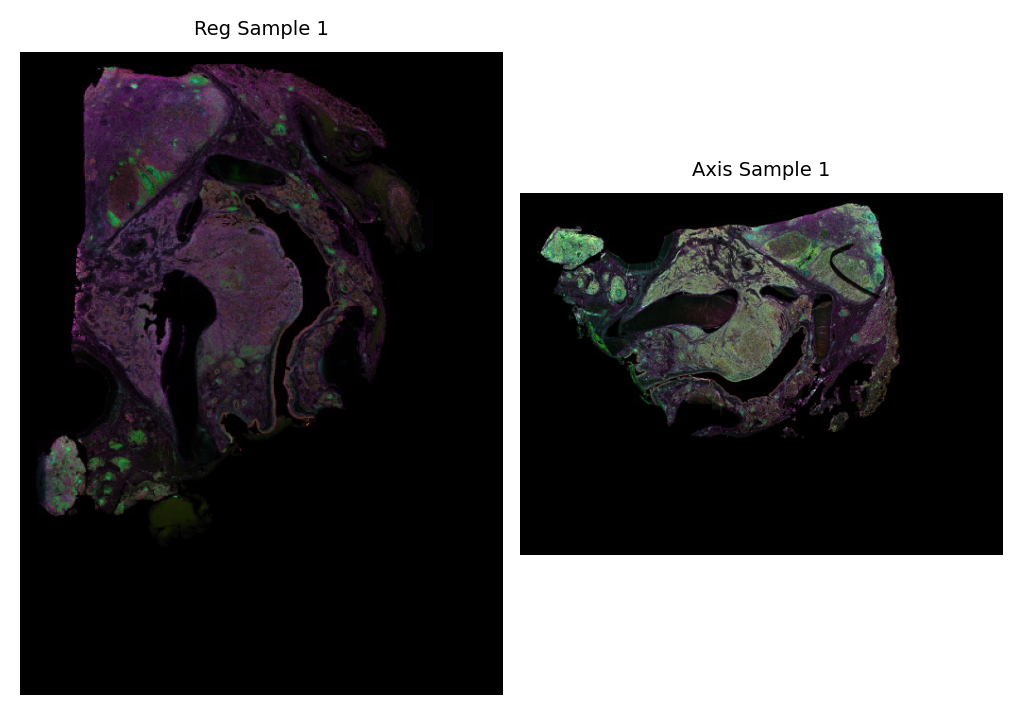

In [21]:

pl.SubPlots(
    pl.ShowImage(sdata=fixed_image, sampleid=fixed_sampleid, title="Reg Sample 1"),  # reg_sampleid
    pl.ShowImage(sdata=moving_image, sampleid=moving_sampleid, title="Axis Sample 1"),  # axis_sampleid
    figsize=(5, 5),
)


## Rigid Registration (Scale 9)

In [ ]:
# this needs to run for just one sample...
# when we have a full pipeline we can run it across multiple samples
#
# the output should be
#   1) a dataframe with the affine parameters
#   2) a dataframe for metrics at each scale,
#   3) the plot similar to plot_transformation_panels

# the way this is written below each transformation matrix will be independent and the final transformation can we written
# as a scaling of the previous
# 

# this should all be wrapped up into a class with attributes for:
#   fixed_sampleid, fixed_slideid, moving_sampleid, moving_slideid, fixed_image, moving_image, scale,
#   transforms (dict), metrics(list of dataframes), affine_parameters(list of dataframes) <- concat the dataframes at the end for time savings
# then methods that run the following depending on the scale
## can use either the affine_initializer or the scaling method for initialization of tform
#

In [117]:

# 
scale = 9
fixed_image_ants = ants_from_sdata(fixed_image[image_id_fixed], scale)
moving_image_ants = ants_from_sdata(moving_image[image_id_moving], scale)
#
affine_init = ants.affine_initializer(
    fixed_image_ants, moving_image_ants, radian_fraction=0.5
)
# Perform registration
registered_image = ants.registration(
    fixed=fixed_image_ants, moving=moving_image_ants, initial_transform=affine_init,
    type_of_transform='Affine',
    aff_metric='MI',  # Mutual Information for same modality often still works best on histo data
    aff_sampling=32,  # Denser sampling than default (e.g., 32 voxels)
    aff_random_sampling_rate=0.25,  # Good for balancing cost/speed
    reg_iterations=(40, 20, 0),  # One resolution: coarser iterations only   
    verbose=False,
)
affine_matrix = get_affine_matrix_from_ants(registered_image['fwdtransforms'][0]) 
#
transformed_image = ants.apply_transforms(
    fixed=fixed_image_ants, moving=moving_image_ants, transformlist=registered_image['fwdtransforms']
)
metrics = []
metrics.append(
    compute_metrics(fixed_sampleid, moving_sampleid, 'original', fixed_image_ants, moving_image_ants)
)
metrics.append(
    compute_metrics(fixed_sampleid, moving_sampleid, scale, fixed_image_ants, transformed_image)
)
merged_df = pd.concat(metrics)
merged_df.head()
affine_parameters = [get_affine_table(fixed_sampleid, moving_image, scale, affine_matrix)]

array([[  0.15825127,  -0.99581498,  99.48627722],
       [  0.88677484,   0.21270408, -10.69394789],
       [  0.        ,   0.        ,   1.        ]])

# Get the scaled transform to use as the input for the next step

In [120]:
from wsifir.utils import get_scaled_ants_transform
#
tform, tform_matrix = get_scaled_ants_transform(affine_matrix, fixed_image[image_id_fixed], 9, 7)
fixed_image_ants = ants_from_sdata(fixed_image[image_id_fixed], 7)
moving_image_ants = ants_from_sdata(moving_image[image_id_moving], 7)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

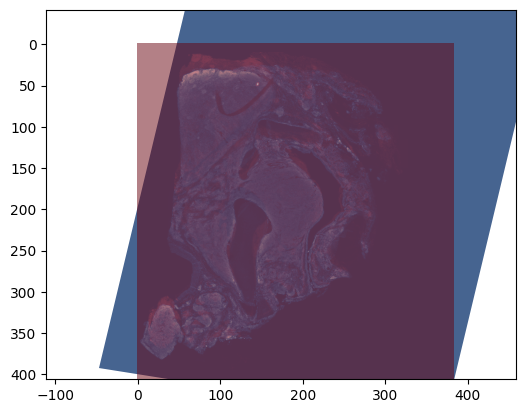

In [121]:
wpl.plot_transformation_mpl(fixed_image_ants, moving_image_ants, tform_matrix,)

In [122]:
transformed_image = ants.apply_transforms(
    fixed=fixed_image_ants, moving=moving_image_ants, transformlist=tform
)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

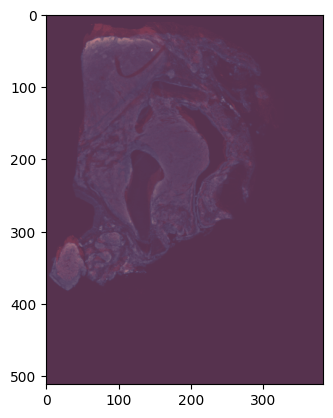

In [123]:
wpl.plot_transformed_image(fixed_image_ants, transformed_image)

## Rigid Regression (Scale 7)

### ANTS Rigid transform

In [134]:

# Perform registration using the scaled transformation as the initial transform
registered_image = ants.registration(
    fixed=fixed_image_ants,
    moving=moving_image_ants,
    initial_transform=tform,  # Use the scaled transformation as the initial transform
    type_of_transform='Affine',
    aff_metric='MI',  # Mutual Information for same modality often still works best on histo data
    aff_sampling=64,  # Denser sampling than default (e.g., 32 voxels)
    aff_random_sampling_rate=0.5,  # Good for balancing cost/speed
    reg_iterations=(100, 50, 25),  # One resolution: coarser iterations only
    verbose=False
)
# Apply the transformation to the moving image
transformed_image_new = ants.apply_transforms(
    fixed=fixed_image_ants,
    moving=moving_image_ants,
    transformlist=registered_image['fwdtransforms']
)
affine_matrix = get_affine_matrix_from_ants(registered_image['fwdtransforms'][0]) 

    

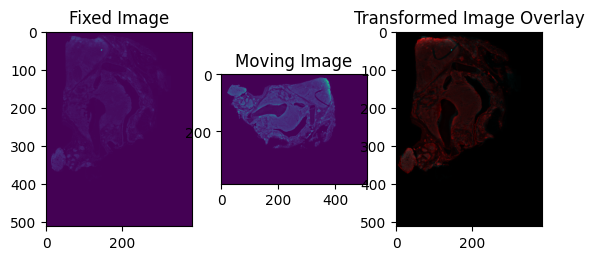

In [135]:
f, a = wpl.plot_transformation_panels(fixed_image_ants, moving_image_ants, transformed_image_new)

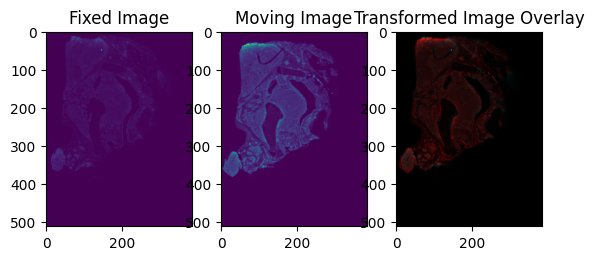

In [136]:
f, a = wpl.plot_transformation_panels(fixed_image_ants, transformed_image, transformed_image_new)

In [137]:
#
metrics.append(
    compute_metrics(fixed_sampleid, moving_sampleid, 7, fixed_image_ants, transformed_image_new)
)
affine_parameters.append(get_affine_table(fixed_sampleid, moving_image, 7, affine_matrix))

## Affine Registration (Scale 5)

### Load in spatial data

## Affine Registration (Scale 3)

### Load in spatial data